In [26]:
import pandas as pd
import numpy as np
import math
import pennylane as qml
import random
import tensorflow as tf

## Data

First, we read in the data, dropping the index and the date.

In [27]:
df = pd.read_csv('dataset_FTSE_prediction_v1.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df=df.drop(columns=['ARIMA'])
df=df[800:]

We identify the dependent and independent variables:

In [28]:
target = "Close"

In [29]:
features = list(df.columns.difference(["Close"]))
features

['Adj Close',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Close_copy',
 'Crude Futures',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'FT3',
 'FT6',
 'FT9',
 'GBP USD ',
 'Gold in USD',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'Volume']

In [30]:
len(features)

24

## Data Processing

To process the data, we first define few terms

In [31]:
random.seed(42)

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [32]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [33]:
df

,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,EMA_10,...,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume,Close_copy
800,-0.664382,-0.518756,-0.212867,-0.376660,-2.096023,-0.541526,-0.618721,-0.664382,1.732245,-0.477768,...,2.765372,-0.923083,-0.285174,-0.957418,0.029832,-0.442130,-0.376660,-0.460099,0.479939,-0.664382
801,-0.646763,-0.405198,-0.255201,-0.392525,-1.648446,-0.526270,-0.600796,-0.646763,1.732245,-0.510207,...,2.765372,-0.947383,-0.387140,-1.015113,-0.059456,-0.471115,-0.392525,-0.463963,-0.746811,-0.646763
802,-0.651849,-0.315221,-0.292326,-0.409164,-1.448674,-0.518568,-0.605967,-0.651849,1.742954,-0.537690,...,2.671345,-0.935746,-0.466173,-1.005142,-0.147868,-0.500101,-0.409164,-0.467120,-0.835320,-0.651849
803,-0.695260,-0.219031,-0.333231,-0.428391,-1.458203,-0.511942,-0.650199,-0.695260,1.607479,-0.568214,...,2.671345,-0.959704,-0.550693,-1.010594,-0.236759,-0.531275,-0.428391,-0.473782,0.314693,-0.695260
804,-0.813687,-0.091393,-0.390878,-0.457822,-1.732959,-0.507468,-0.771680,-0.813687,1.580170,-0.615116,...,2.671345,-0.945671,-0.686218,-1.139791,-0.336992,-0.572362,-0.457822,-0.483073,-0.020605,-0.813687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,0.764009,-0.149978,0.687472,0.738442,0.156114,0.753486,0.755674,0.764009,1.389541,0.775099,...,-0.713624,1.462017,-0.279086,0.658465,-0.531071,0.759355,0.738442,0.919877,-1.255627,0.764009
3135,0.792344,-0.320354,0.718714,0.721971,0.421769,0.683547,0.781440,0.792344,1.353128,0.781322,...,-0.807650,1.459964,-0.237484,0.628980,-0.476021,0.779237,0.721971,0.918719,-1.228554,0.792344
3136,0.858642,-0.360917,0.725812,0.717688,0.821349,0.666530,0.841517,0.858642,1.392218,0.798688,...,-0.807650,1.463044,-0.160380,0.692283,-0.415414,0.804912,0.717688,0.916662,-0.521709,0.858642
3137,0.892608,-0.370429,0.727517,0.716729,1.019851,0.662588,0.872183,0.892608,1.391683,0.819186,...,-0.807650,1.479814,-0.076886,0.758568,-0.348987,0.834026,0.716729,0.915488,-0.821082,0.892608


In [34]:
# Data for regression model
sequence_length_reg = window_reg =20 # Number of time steps that will be inputted into LSTM network

def create_dataset_reg(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,5):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return X_store,y_store

X_reg,y_reg = create_dataset_reg(
    df,
    target=target,
    features=features,
    lookback=sequence_length_reg, window=window_reg)

print(np.array(X_reg).shape, np.array(y_reg).shape)

(460, 20, 24) (460, 20)


In [35]:
indices = tf.range(start=0, limit=tf.shape(X_reg)[0])
shuffled_indices = tf.random.shuffle(indices)

In [36]:
X_reg = tf.gather(X_reg, shuffled_indices)
y_reg = tf.gather(y_reg, shuffled_indices)

In [37]:
# Train test split
m=np.array(X_reg).shape[0] # get first dimension
size=int(m*0.9)
X_train_reg=X_reg[:size]
y_train_reg=y_reg[:size]
X_test_reg=X_reg[size:]
y_test_reg=y_reg[size:]
print('Shape of train is',np.array(X_train_reg).shape,'and',np.array(y_train_reg).shape)
print('Shape os test is',np.array(X_test_reg).shape,'and',np.array(y_test_reg).shape)

Shape of train is (414, 20, 24) and (414, 20)
Shape os test is (46, 20, 24) and (46, 20)


In [38]:
X_train_reg_=np.array([inner for outer in X_train_reg for inner in outer])
print(X_train_reg_.shape)
y_train_reg_=np.array([inner for outer in y_train_reg for inner in outer])
print(y_train_reg_.shape)

(8280, 24)
(8280,)


In [39]:
X_test_reg_=np.array([inner for outer in X_test_reg for inner in outer])
print(X_test_reg_.shape)
y_test_reg_=np.array([inner for outer in y_test_reg for inner in outer])
print(y_test_reg_.shape)

(920, 24)
(920,)


In [40]:
# Prepare test data
X_check_reg=(df[features].values)[len(df)-window_reg-sequence_length_reg:len(df)- window_reg]
y_check_reg=(df[target].values)[len(df)-window_reg:len(df)]

In [41]:
# import torch

# QNN

In [42]:
# Define QNode
n_layers=2
nqubits = 10
device = qml.device('default.qubit.tf', wires=nqubits)
@qml.qnode(device, interface="tf", diff_method="backprop")
def qnode(inputs, weights):
    # Preproccess input data to encode the initial state.
    ry_params = [math.atan(feature) for feature in inputs]
    rz_params = [math.atan(feature**2) for feature in inputs]
    for i in range(nqubits):
        qml.Hadamard(wires=i)
        qml.RY(ry_params[i], wires=i)
        qml.RZ(ry_params[i], wires=i)
    qml.templates.AngleEmbedding(inputs, wires=range(nqubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(nqubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(nqubits)]
# define weight_shapes
weight_shapes = {"weights": (n_layers, nqubits, 3)}

In [43]:
from tensorflow.keras import regularizers, initializers
from tensorflow.keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Model

In [44]:
input_ = Input((24,)) # feature
den1=Dense(10, use_bias=True,activation='relu')(input_) 
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=nqubits)(den1)
den5=Dense(1, use_bias=True,activation='linear')(qlayer)
model = Model(inputs=[input_], outputs=den5)

In [45]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(opt, loss=loss_fn)

In [46]:
import time

In [ ]:
start=time.time()
model_history = model.fit(X_train_reg_, y_train_reg_,
                    validation_data=(X_test_reg_, y_test_reg_),
                   batch_size=32, 
                   epochs=100,  # total epoch
                   )
end=time.time()

Epoch 1/100
 30/259 [==>...........................] - ETA: 1:17:46 - loss: 0.9666

In [ ]:
print(end-start)

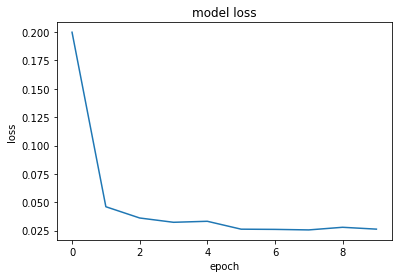

In [45]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
def mae_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error/len(actual)

def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += (predicted[i] - actual[i])**2
    return (sum_error/len(actual))**0.5

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
y_check_pred_qnn = model.predict(X_check_reg)
y_check_pred_qnn=y_check_pred_qnn.flatten()
mae_check_qnn = mean_absolute_error(y_check_reg* target_stdev + target_mean, y_check_pred_qnn* target_stdev + target_mean)
print('Mean absolute Error : ',mae_check_qnn)
rmse_check_qnn = mean_squared_error(y_check_reg* target_stdev + target_mean, y_check_pred_qnn* target_stdev + target_mean, squared=False)
print('Root Mean Squared Error : ',rmse_check_qnn)

Mean absolute Error :  95.0752180989583
Root Mean Squared Error :  124.08813078115676


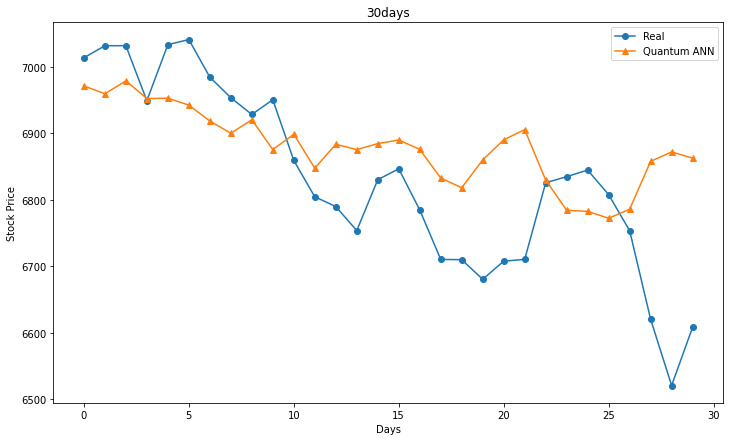

In [44]:
plt.figure(figsize=(12, 7))
plt.plot(y_check_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_pred_qnn* target_stdev + target_mean, label = "Quantum ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title(str(window_reg)+'days')
plt.legend()
plt.show()

In [41]:
save_data=[y_check_reg* target_stdev + target_mean,
          y_check_pred_qnn* target_stdev + target_mean]

In [106]:
# import csv 
# # name of csv file   
# filename = "QNN_result_vqc.csv"
      
# # writing to csv file   
# with open(filename, 'w') as csvfile:   
#     # creating a csv writer object   
#     csvwriter = csv.writer(csvfile)     
          
#     # writing the data rows   
#     csvwriter.writerows(save_data)